In [1]:
import itertools
import sqlite3
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from plotly_gif import GIF, three_d_scatter_rotate

In [2]:
def fetch_data(db_path, simulation_id):
    conn = sqlite3.connect(db_path)
    query = f"SELECT mu_s, mu_a, g, reflectance FROM mclut WHERE simulation_id = {simulation_id}"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def plot_wireframe(df):
    unique_g_values = df['g'].unique()
    for g in unique_g_values:
        gif = GIF()
        subset = df[df['g'] == g]
        
        # Pivot data for wireframe plotting
        pivot_table = subset.pivot(index='mu_s', columns='mu_a', values='reflectance')
        mu_s_values = pivot_table.index.values
        mu_a_values = pivot_table.columns.values
        reflectance_values = pivot_table.values
        
        mu_s_grid, mu_a_grid = np.meshgrid(mu_s_values, mu_a_values, indexing='ij')
        
        # Generate wireframe lines
        lines = []
        for i in range(len(mu_s_values)):
            lines.append(go.Scatter3d(x=[mu_s_values[i]]*len(mu_a_values), 
                                      y=mu_a_values, 
                                      z=reflectance_values[i, :], 
                                      mode='lines',
                                      line=dict(color='black', width=3)))
        
        for j in range(len(mu_a_values)):
            lines.append(go.Scatter3d(x=mu_s_values, 
                                      y=[mu_a_values[j]]*len(mu_s_values), 
                                      z=reflectance_values[:, j], 
                                      mode='lines',
                                      line=dict(color='black', width=3)))
        
        fig = go.Figure(data=lines)
        fig.update_layout(title=f"Reflectance Wireframe vs mu_s & mu_a (g={g})",
                          scene=dict(xaxis_title='mu_s', yaxis_title='mu_a', zaxis_title='Reflectance'))
        three_d_scatter_rotate(gif, fig)
        fig.show()
        gif.create_gif(gif_path='mclut_wireframe_g-{g}.gif'.format(g=g))


In [3]:
df = fetch_data('databases/hsdfm_data.db', 32)
df

,mu_s,mu_a,g,reflectance
0,0.0,1.0,0.9,0.000000
1,0.0,3.5,0.9,0.000000
2,0.0,6.0,0.9,0.000000
3,0.0,8.5,0.9,0.000000
4,0.0,11.0,0.9,0.000000
...,...,...,...,...
415,50.0,38.5,0.9,0.001895
416,50.0,41.0,0.9,0.001693
417,50.0,43.5,0.9,0.001575
418,50.0,46.0,0.9,0.001366


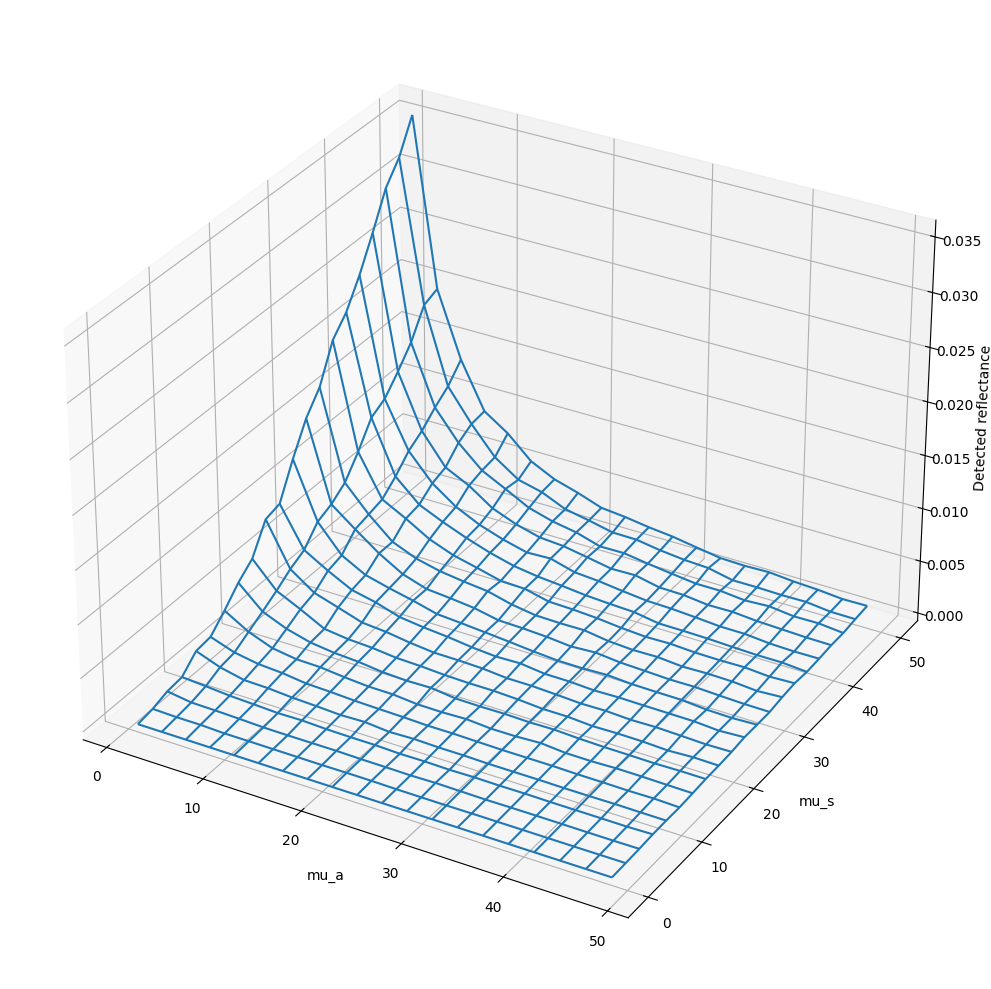

In [9]:
x = df['mu_s'].unique()
y = df['mu_a'].unique()
X, Y = np.meshgrid(x, y, indexing='ij')
Z = np.reshape(df['reflectance'], (len(x), len(y)))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Y, X, Z, rstride=1, cstride=1)
# ax.invert_yaxis()
ax.set_xlabel('mu_a')
ax.set_ylabel('mu_s')
ax.set_zlabel('Detected reflectance')
fig.tight_layout()
plt.show()

## Comparison to diffusion approximation

In [ ]:
from tqdm import tqdm

mu_s_array = np.arange(0, 50, 1)
mu_a_array = np.arange(1, 50, 1)
tissue_n = 1.33
collection_n = 1.33
for mu_s, mu_a in tqdm(itertools.product(mu_s_array, mu_a_array), 
                       desc='Diffusion approximation', total=len(mu_s_array) * len(mu_a_array)):
    R = diffusion_appoximation(mu_s=mu_s, mu_a=mu_a, n_tissue=tissue_n, n_collection=collection_n)